# Decision Tree Tutorial: Titanic Survival Prediction

## Introduction

In this lab, we’ll explore classification using decision trees, a
fundamental machine learning algorithm. We’ll use the famous Titanic
dataset to predict passenger survival based on various features. This
approach mirrors what you’ve seen in the lecture materials on machine
learning. By the end of this session, you’ll have built a decision tree
classifier, evaluated its performance, and applied these concepts to a
new dataset.

## Learning Objectives

By the end of this lab, you should be able to:

1.  Preprocess data for classification tasks
2.  Build and visualize a decision tree classifier
3.  Evaluate model performance using various metrics
4.  Apply these skills to a new dataset

## Part 1: Setup and Data Exploration

First, let’s import the necessary libraries and load the Titanic
dataset.

In [7]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.preprocessing import LabelEncoder

# Set the style for plots
sns.set_style('whitegrid')

# Load the Titanic dataset
url = "https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/titanic.csv"
titanic = pd.read_csv(url)

# Display the first few rows
print(titanic.head())

   Survived  Pclass                                               Name  \
0         0       3                             Mr. Owen Harris Braund   
1         1       1  Mrs. John Bradley (Florence Briggs Thayer) Cum...   
2         1       3                              Miss. Laina Heikkinen   
3         1       1        Mrs. Jacques Heath (Lily May Peel) Futrelle   
4         0       3                            Mr. William Henry Allen   

      Sex   Age  Siblings/Spouses Aboard  Parents/Children Aboard     Fare  
0    male  22.0                        1                        0   7.2500  
1  female  38.0                        1                        0  71.2833  
2  female  26.0                        0                        0   7.9250  
3  female  35.0                        1                        0  53.1000  
4    male  35.0                        0                        0   8.0500  


Now, let’s explore the data to understand what we’re working with.

In [8]:
# Check basic information about the dataset
print("\nDataset Info:")
print(titanic.info())

print("\nSummary Statistics:")
print(titanic.describe())

# Check for missing values
print("\nMissing Values:")
print(titanic.isnull().sum())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887 entries, 0 to 886
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Survived                 887 non-null    int64  
 1   Pclass                   887 non-null    int64  
 2   Name                     887 non-null    object 
 3   Sex                      887 non-null    object 
 4   Age                      887 non-null    float64
 5   Siblings/Spouses Aboard  887 non-null    int64  
 6   Parents/Children Aboard  887 non-null    int64  
 7   Fare                     887 non-null    float64
dtypes: float64(2), int64(4), object(2)
memory usage: 55.6+ KB
None

Summary Statistics:
         Survived      Pclass         Age  Siblings/Spouses Aboard  \
count  887.000000  887.000000  887.000000               887.000000   
mean     0.385569    2.305524   29.471443                 0.525366   
std      0.487004    0.836662   14.121908 

Let’s visualize some of the key features and their relationship with
survival.

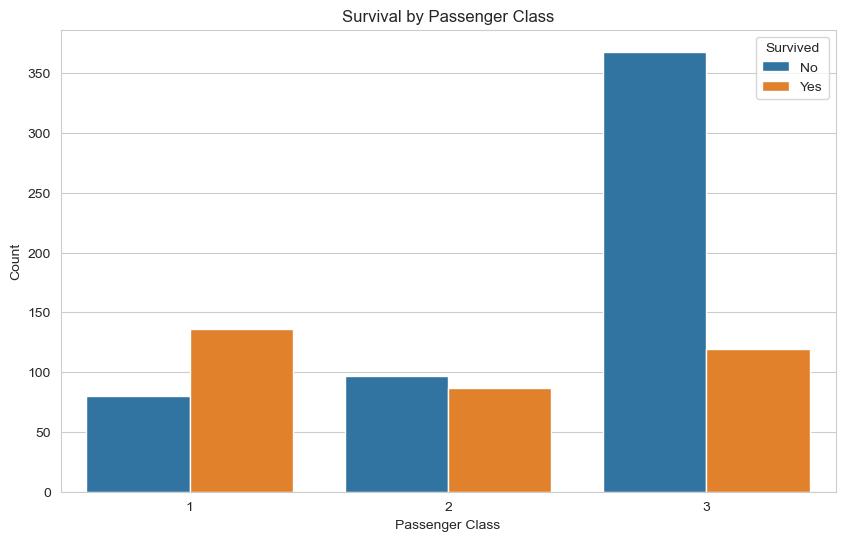

In [9]:
# Plot survival rate by passenger class
plt.figure(figsize=(10, 6))
sns.countplot(x='Pclass', hue='Survived', data=titanic)
plt.title('Survival by Passenger Class')
plt.xlabel('Passenger Class')
plt.ylabel('Count')
plt.legend(title='Survived', labels=['No', 'Yes'])
plt.show()

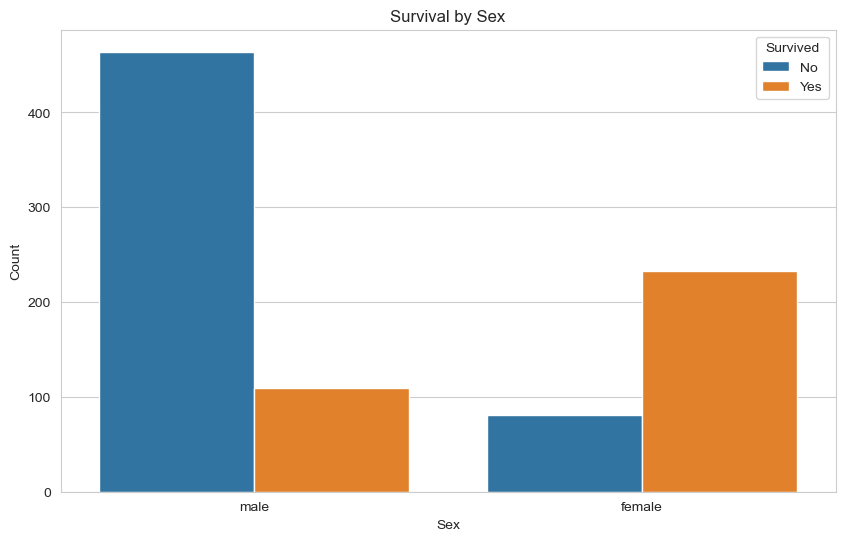

In [10]:
# Plot survival rate by sex
plt.figure(figsize=(10, 6))
sns.countplot(x='Sex', hue='Survived', data=titanic)
plt.title('Survival by Sex')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.legend(title='Survived', labels=['No', 'Yes'])
plt.show()

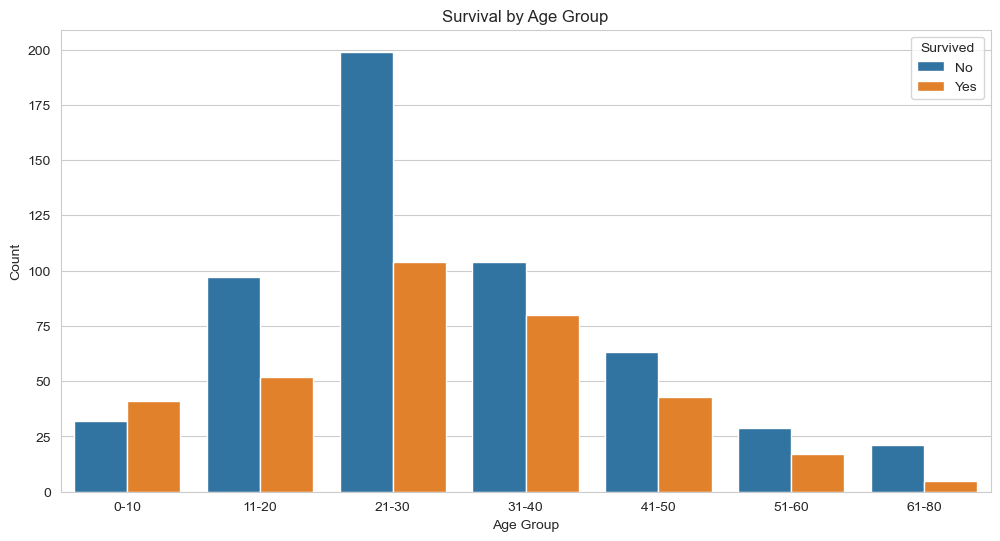

In [11]:
# Plot survival rate by age group
titanic['AgeGroup'] = pd.cut(titanic['Age'], bins=[0, 10, 20, 30, 40, 50, 60, 80], labels=['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-80'])
plt.figure(figsize=(12, 6))
sns.countplot(x='AgeGroup', hue='Survived', data=titanic)
plt.title('Survival by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.legend(title='Survived', labels=['No', 'Yes'])
plt.show()

## Part 2: Data Preprocessing

Before we build our model, we need to preprocess the data, handle
missing values, and prepare it for the decision tree algorithm.

In [12]:
# Select features and target
titanic_data = titanic.copy()

# Handle missing values: note that alternatively you could drop all cases 
# without age if you think its an important factor
titanic_data['Age'].fillna(titanic_data['Age'].median(), inplace=True)

# Create a 'FamilySize' feature
titanic_data['FamilySize'] = titanic_data['Siblings/Spouses Aboard'] + titanic_data['Parents/Children Aboard']

# Convert categorical variables to numerical
label_encoder = LabelEncoder()
titanic_data['Sex'] = label_encoder.fit_transform(titanic_data['Sex'])  # Male: 1, Female: 0

# Select features for our model 
features = ['Pclass', 'Sex', 'Age', 'FamilySize']
X = titanic_data[features]
y = titanic_data['Survived']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (620, 4)
Testing set shape: (267, 4)


/var/folders/jk/pk02lhls259fnypkd7y6tbfw0000gn/T/ipykernel_35770/827864854.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic_data['Age'].fillna(titanic_data['Age'].median(), inplace=True)


## Part 3: Building a Decision Tree Classifier

Now, let’s build a decision tree classifier and train it on our data.

In [13]:
# Create a decision tree classifier
tree_clf = DecisionTreeClassifier(max_depth=3, random_state=42)

# Train the classifier
tree_clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = tree_clf.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.8015


## Part 4: Visualizing the Decision Tree

Let’s visualize our decision tree to understand how it’s making
predictions.

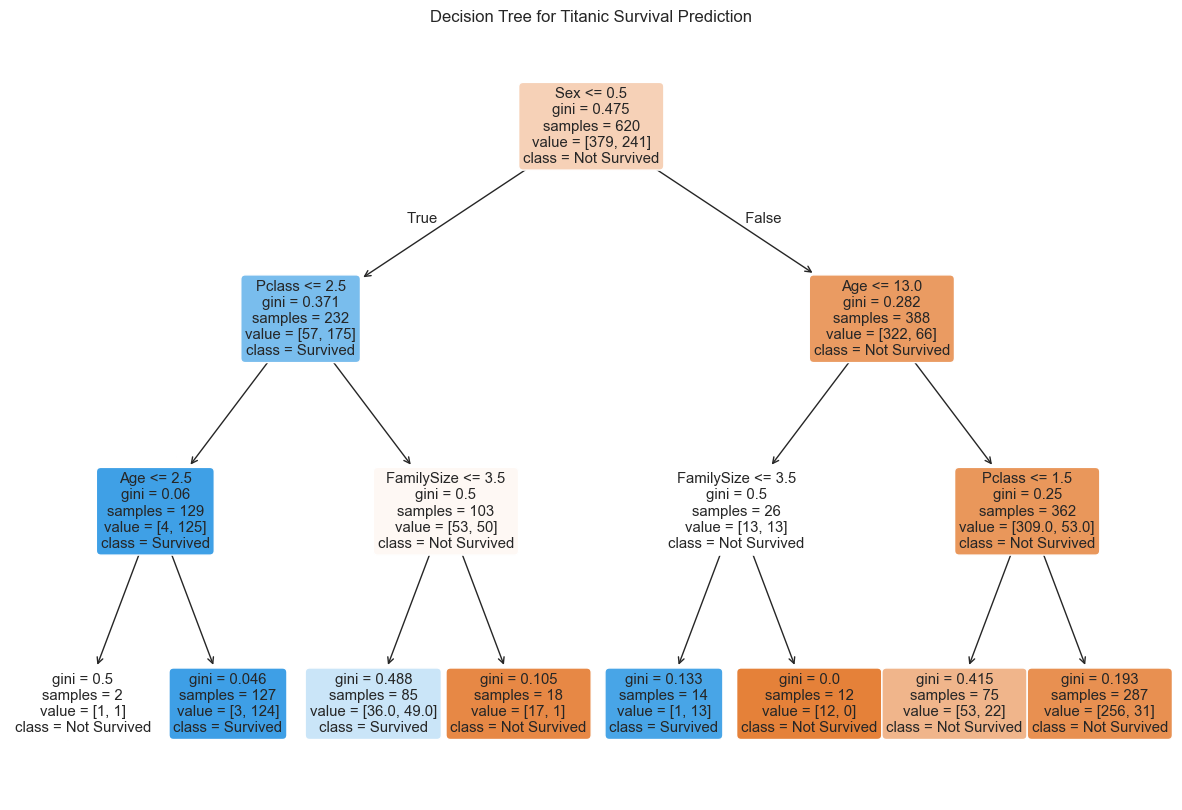

In [14]:
# Plot the decision tree
plt.figure(figsize=(15, 10))
plot_tree(tree_clf, 
          feature_names=features, 
          class_names=['Not Survived', 'Survived'],
          filled=True, 
          rounded=True)
plt.title("Decision Tree for Titanic Survival Prediction")
plt.show()

## Part 5: Evaluating Model Performance

Now, let’s evaluate our model using various metrics to understand its
strengths and weaknesses.

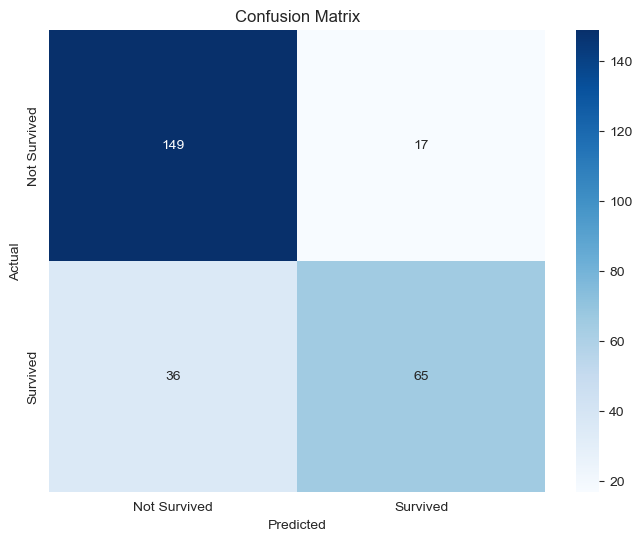

In [15]:
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Survived', 'Survived'],
            yticklabels=['Not Survived', 'Survived'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [16]:
# Calculate sensitivity (true positive rate) and specificity (true negative rate)
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print(f"Sensitivity (True Positive Rate): {sensitivity:.4f}")
print(f"Specificity (True Negative Rate): {specificity:.4f}")

Sensitivity (True Positive Rate): 0.6436
Specificity (True Negative Rate): 0.8976


In [17]:
# Display classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       166
           1       0.79      0.64      0.71       101

    accuracy                           0.80       267
   macro avg       0.80      0.77      0.78       267
weighted avg       0.80      0.80      0.80       267



In [18]:
# Calculate Brier score
from sklearn.metrics import brier_score_loss
y_prob = tree_clf.predict_proba(X_test)[:, 1]
brier_score = brier_score_loss(y_test, y_prob)
print(f"Brier Score: {brier_score:.4f}")
print("Note: Lower Brier score values indicate better calibrated predictions")

Brier Score: 0.1458
Note: Lower Brier score values indicate better calibrated predictions


In [19]:
# Baseline Brier score (predicting the mean probability)
y_pred_baseline = np.ones_like(y_test) * y_test.mean()
brier_baseline = brier_score_loss(y_test, y_pred_baseline)
print(f"Baseline Brier Score: {brier_baseline:.4f}")
print(f"Brier Score Improvement: {(1 - brier_score/brier_baseline) * 100:.2f}%")

Baseline Brier Score: 0.2352
Brier Score Improvement: 38.01%


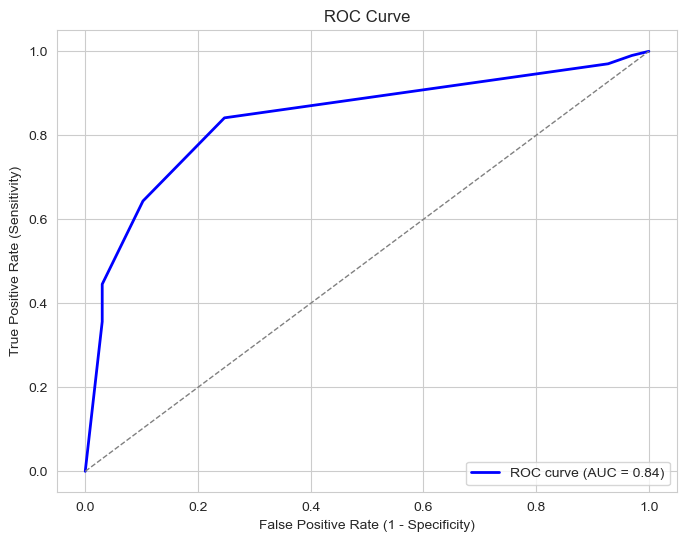

In [20]:
# Calculate ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

## Part 6: Adjusting Model Parameters

Let’s experiment with different parameters to see if we can improve our
model.

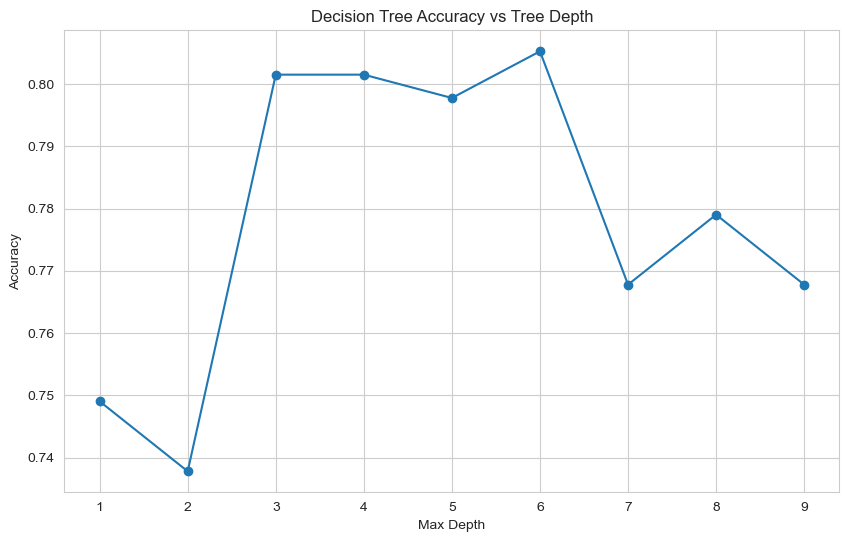

Best max_depth: 6
Final Model Accuracy: 0.8052


In [21]:
# Let's try different max_depth values
depths = range(1, 10)
accuracy_scores = []

for depth in depths:
    tree_model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    tree_model.fit(X_train, y_train)
    y_pred = tree_model.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))

# Plot accuracy for different tree depths
plt.figure(figsize=(10, 6))
plt.plot(depths, accuracy_scores, marker='o')
plt.title('Decision Tree Accuracy vs Tree Depth')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.xticks(depths)
plt.grid(True)
plt.show()

# Find the best depth
best_depth = depths[np.argmax(accuracy_scores)]
print(f"Best max_depth: {best_depth}")

# Build final model with the best depth
final_tree = DecisionTreeClassifier(max_depth=best_depth, random_state=42)
final_tree.fit(X_train, y_train)
final_pred = final_tree.predict(X_test)
final_accuracy = accuracy_score(y_test, final_pred)
print(f"Final Model Accuracy: {final_accuracy:.4f}")

## Part 7: Applying to a New Dataset - Heart Disease Classification

Now, let’s apply what we’ve learned to a different dataset. We’ll use
the Heart Disease dataset from sklearn to classify whether a patient has
heart disease based on various clinical features.

In [43]:
heart_df = pd.read_csv('heart_disease.csv') #make sure you've downloaded and placed it in the same folder as this file

# Display information about the dataset
print(heart_df.head())

   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   3       145   233    1        0      150      0      2.3      0   
1   37    1   2       130   250    0        1      187      0      3.5      0   
2   41    0   1       130   204    0        0      172      0      1.4      2   
3   56    1   1       120   236    0        1      178      0      0.8      2   
4   57    0   0       120   354    0        1      163      1      0.6      2   

   ca  thal  target  
0   0     1       1  
1   0     2       1  
2   0     2       1  
3   0     2       1  
4   0     2       1  


## Exercises

Now it’s your turn to apply what you’ve learned. Complete the following
exercises:

### Exercise 1: Preprocessing the Heart Disease Data

Preprocess the heart disease dataset by: 1. Exploring the dataset to
understand the features 2. Checking for missing values 3. Standardizing
numerical features 4. Splitting the data into training and testing sets

### Exercise 2: Building and Evaluating a Decision Tree

Build a decision tree classifier to predict heart disease: 1. Create and
train the model with a max_depth of 3. Make predictions and calculate
accuracy 3. Visualize the tree 4. Compute and display feature importance

### Exercise 3: Age-Based Risk Analysis

The heart disease dataset includes patients’ ages. Medical literature
suggests that heart disease risk increases with age.

1.  Create a new binary feature ‘HighRiskAge’ for patients over 55 years
    old
2.  Build a decision tree to predict heart disease using only this
    feature
3.  Compare its accuracy to the full model from Exercise 2
4.  Add this feature to the full model and see if it improves accuracy

### Exercise 4: Cross-Validation and Parameter Tuning

Implement cross-validation to find the best parameters for your heart
disease decision tree model: 
1. Try different values for max_depth,
min_samples_split, and min_samples_leaf
2. Use GridSearchCV to perform
the search
3. Report the best parameters and the corresponding
validation score
4. Compare the performance of the tuned model with your
original model using the Brier score as well as a ROC curve.

## Conclusion

In this lab, you’ve learned how to build and evaluate decision tree
classifiers for different classification tasks. You’ve applied these
skills to both the Titanic survival prediction problem and a heart
disease classification task.

Working with the heart disease dataset offers a practical application of
machine learning in healthcare, where early prediction of heart disease
can help in preventive care and treatment planning.

Key takeaways from this lab: 
- Decision trees provide an interpretable
model for classification
- Preprocessing and feature engineering can
significantly impact model performance
- Proper evaluation metrics are
essential for understanding model strengths and weaknesses
- Cross-validation helps in finding optimal model parameters 

These skills form a foundation for more advanced classification models
that you’ll explore in future sessions.